# 1D Heat Equation Comparison: PINN vs FDM vs Exact

Using device: mps
Epoch 1000/5000  Loss: 3.948e-03 (pde 3.270e-03, ic 7.493e-05, bc 6.029e-04)
Epoch 2000/5000  Loss: 9.384e-04 (pde 6.340e-04, ic 1.023e-05, bc 2.942e-04)
Epoch 3000/5000  Loss: 5.020e-04 (pde 2.729e-04, ic 3.196e-06, bc 2.259e-04)
Epoch 4000/5000  Loss: 1.078e-03 (pde 2.000e-04, ic 4.328e-06, bc 8.732e-04)
Epoch 5000/5000  Loss: 2.382e-04 (pde 1.072e-04, ic 2.347e-06, bc 1.287e-04)


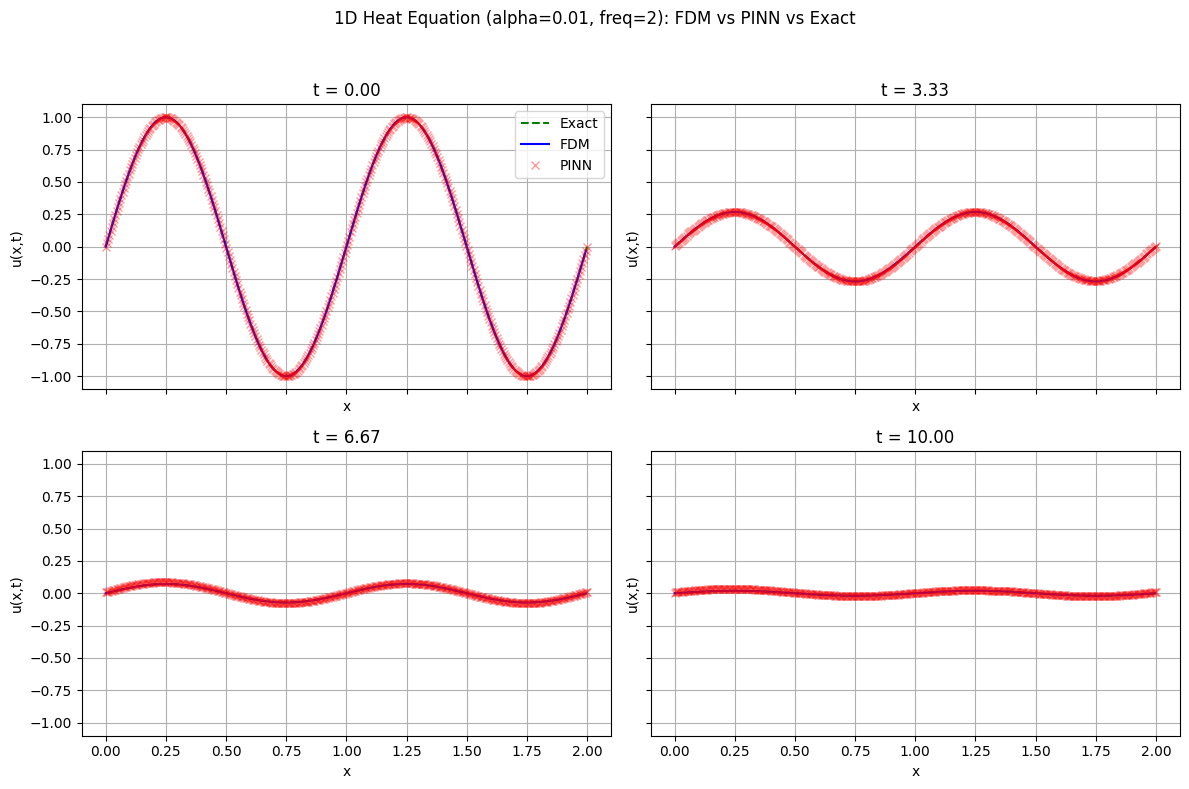

In [2]:
# ==================================================
# This notebook demonstrates:
# 1. The exact solution of the heat equation with periodic BC, amplitude=1, frequency=2, alpha=0.01.
# 2. A finite-difference explicit solver (FDM).
# 3. A PINN using a Fourier feature embedding (Fourier Neural Operator style) with explicit periodic BC enforcement.
# 4. Comparison plots at t = [0, 3.33, 6.67, 10.00].

# ## 1. Imports and Utility Functions
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.autograd import grad

# Device selection: assume MPS on Mac
device = torch.device('mps')  # on Apple Silicon
print(f"Using device: {device}")

# Exact solution for u_t = alpha u_xx, initial u(x,0)=sin(k * 2π x / L)
class HeatExact:
    def __init__(self, alpha=0.01, k=2, L=2.0):
        self.alpha = alpha
        self.k = k
        self.L = L
    def __call__(self, x, t):
        decay = math.exp(-self.alpha * (2*math.pi*self.k/self.L)**2 * t)
        phase = 2*math.pi*self.k * x / self.L
        return decay * np.sin(phase)

# ## 2. Finite Difference Solver
class HeatFDM:
    def __init__(self, alpha=0.01, k=2, L=2.0, Nx=400, dt=1e-4, t_max=10.0):
        self.alpha = alpha
        self.k = k
        self.L = L
        self.Nx = Nx
        self.dx = L / Nx
        self.dt = dt
        self.t_max = t_max
        self.x = np.linspace(0, L, Nx, endpoint=False)
        self.u = np.sin(2 * np.pi * k * self.x / L)
        self.u_hist = {}

    def step(self):
        u = self.u
        u_ip = np.roll(u, -1)
        u_im = np.roll(u, +1)
        self.u = u + self.alpha * self.dt / (self.dx**2) * (u_ip - 2*u + u_im)

    def solve(self, times):
        self.u = np.sin(2 * np.pi * self.k * self.x / self.L)
        self.u_hist = {t: None for t in times}
        t = 0.0
        times_sorted = sorted(times)
        next_time = times_sorted.pop(0)
        while t < self.t_max + self.dt:
            if t >= next_time - 1e-8:
                self.u_hist[next_time] = self.u.copy()
                if times_sorted:
                    next_time = times_sorted.pop(0)
                else:
                    break
            self.step()
            t += self.dt
        return self.x, self.u_hist

# ## 3. PINN with Fourier Features
class FourierFeatures(nn.Module):
    def __init__(self, in_dim, mapping_size=100, scale=1.0):
        super().__init__()
        B = torch.randn(in_dim, mapping_size) * scale
        self.register_buffer('B', B)
    def forward(self, x):
        x_proj = 2*math.pi * x @ self.B
        return torch.cat([torch.sin(x_proj), torch.cos(x_proj)], dim=-1)

class PINNHeat(nn.Module):
    def __init__(self, alpha=0.01, hidden_layers=[128,128], fourier_features=100, L=2.0):
        super().__init__()
        self.alpha = alpha
        self.L = L
        self.ff = FourierFeatures(2, fourier_features)
        layers = []
        in_dim = 2 * fourier_features
        for h in hidden_layers:
            layers += [nn.Linear(in_dim, h), nn.Tanh()]
            in_dim = h
        layers += [nn.Linear(in_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, t):
        X = torch.cat([x, t], dim=-1)
        phi = self.ff(X)
        return self.net(phi)

    def loss_pde(self, x, t):
        x.requires_grad_(True)
        t.requires_grad_(True)
        u = self.forward(x, t)
        u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return torch.mean((u_t - self.alpha * u_xx)**2)

    def loss_ic(self, x0):
        u0_true = torch.sin(2*math.pi * 2 * x0 / self.L)
        u0_pred = self.forward(x0, torch.zeros_like(x0))
        return torch.mean((u0_pred - u0_true)**2)

    def loss_bc(self, t_b):
        # enforce periodic: u(0,t)=u(L,t) and u_x(0,t)=u_x(L,t)
        x0 = torch.zeros_like(t_b, requires_grad=True)
        xL = torch.ones_like(t_b, requires_grad=True) * self.L
        u0 = self.forward(x0, t_b)
        uL = self.forward(xL, t_b)
        u0_x = grad(u0, x0, grad_outputs=torch.ones_like(u0), create_graph=True)[0]
        uL_x = grad(uL, xL, grad_outputs=torch.ones_like(uL), create_graph=True)[0]
        loss_val = torch.mean((u0 - uL)**2) + torch.mean((u0_x - uL_x)**2)
        return loss_val

# Training routine
def train_pinn(model, epochs=15000, lr=1e-3, N_pde=2000, N_ic=2000, N_bc=2000):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        x_pde = torch.rand(N_pde,1, device=device) * model.L
        t_pde = torch.rand(N_pde,1, device=device) * 10.0
        x_ic  = torch.rand(N_ic,1,  device=device) * model.L
        t_bc  = torch.rand(N_bc,1,  device=device) * 10.0
        lpde = model.loss_pde(x_pde, t_pde)
        lic  = model.loss_ic(x_ic)
        lbc  = model.loss_bc(t_bc)
        loss = lpde + lic + lbc
        optimizer.zero_grad(); loss.backward(); optimizer.step()
        if ep % 1000 == 0:
            print(f"Epoch {ep}/{epochs}  Loss: {loss.item():.3e} (pde {lpde.item():.3e}, ic {lic.item():.3e}, bc {lbc.item():.3e})")
    return model



# ## 4. Putting It All Together and Plotting
if __name__ == '__main__':
    L = 2.0; alpha = 0.01; k = 2
    times = [0.0, 3.33, 6.67, 10.0]

    # Exact solution
    exact = HeatExact(alpha=alpha, k=k, L=L)

    # FDM solver
    fdm = HeatFDM(alpha=alpha, k=k, L=L, Nx=400, dt=1e-4, t_max=max(times))
    x_fd, u_fd_hist = fdm.solve(times)

    # PINN training
    pinn = PINNHeat(alpha=alpha, hidden_layers=[128,128], fourier_features=100, L=L).to(device)
    pinn = train_pinn(pinn, epochs=5000, lr=1e-3)

    # Evaluate PINN
    x_plot = np.linspace(0, L, 400)
    x_t = torch.tensor(x_plot, dtype=torch.float32, device=device).unsqueeze(-1)
    u_pinn_hist = {}
    for t in times:
        t_t = torch.ones_like(x_t) * t
        with torch.no_grad():
            u_pinn_hist[t] = pinn(x_t, t_t).cpu().numpy().flatten()

    # Plot comparisons
    fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True, sharey=True)
    for ax, t in zip(axes.flatten(), times):
        ax.plot(x_plot, exact(x_plot, t), 'g--', label='Exact')
        ax.plot(x_fd,     u_fd_hist[t],   'b-',  label='FDM')
        ax.plot(x_plot,   u_pinn_hist[t], 'r x', label='PINN', alpha=0.4)
        ax.set_title(f"t = {t:.2f}")
        ax.grid(True)
    axes.flatten()[0].legend()
    for ax in axes.flatten(): ax.set_xlabel('x'); ax.set_ylabel('u(x,t)')
    fig.suptitle(f"1D Heat Equation (alpha={alpha}, freq={k}): FDM vs PINN vs Exact")
    plt.tight_layout(rect=[0,0,1,0.95])
    plt.show()


# 1.3 minutes - Loss: 2.382e-04 (pde 1.072e-04, ic 2.347e-06, bc 1.287e-04) - 5000 iterations

Using device: mps
Epoch 500: loss 8.15e-03
Epoch 1000: loss 3.72e-03
Epoch 1500: loss 1.33e-03
Epoch 2000: loss 1.81e-03
Epoch 2500: loss 3.88e-03
Epoch 3000: loss 1.53e-03
Epoch 3500: loss 2.30e-04
Epoch 4000: loss 1.29e-03
Epoch 4500: loss 3.17e-04
Epoch 5000: loss 2.00e-04


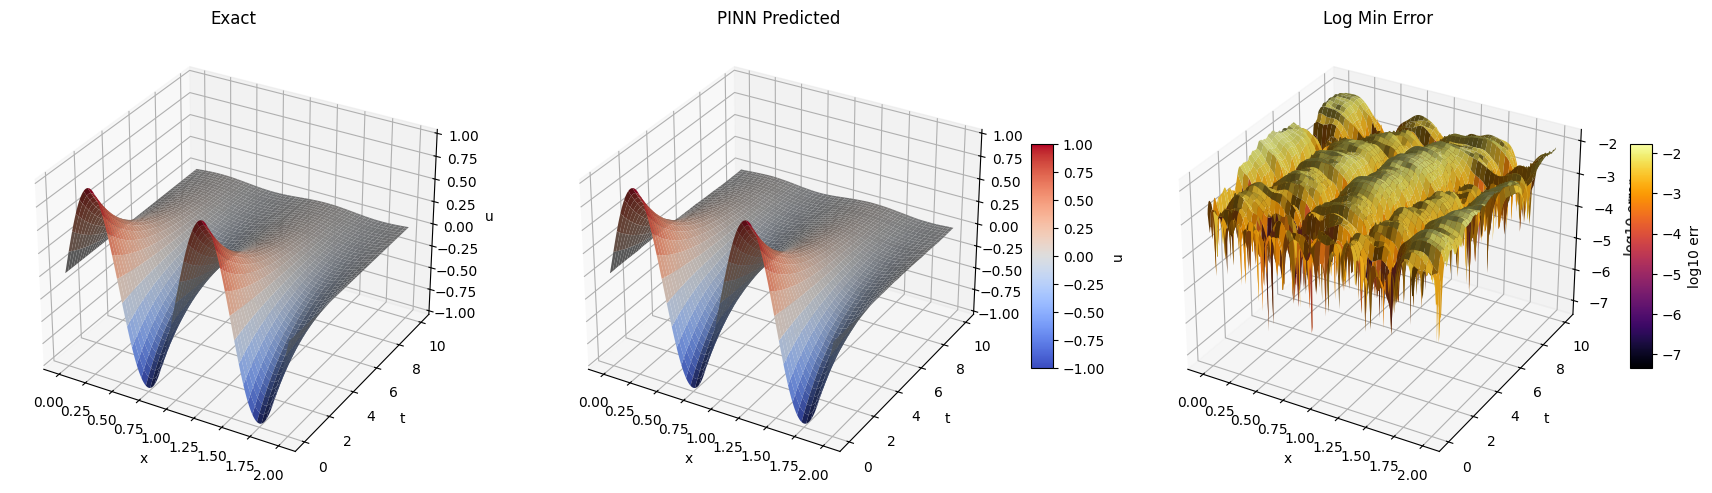

In [18]:
import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm, colors
from torch.autograd import grad

# --- Device ---
device = torch.device('mps')   # assume Apple Silicon
print("Using device:", device)

# --- 1D Exact solution class ---
class HeatExact:
    def __init__(self, alpha=0.01, k=2, L=2.0):
        self.alpha, self.k, self.L = alpha, k, L
    def __call__(self, x, t):
        # x,t numpy arrays
        decay = np.exp(-self.alpha * (2*np.pi*self.k/self.L)**2 * t)
        phase = 2*np.pi*self.k * x / self.L
        return decay * np.sin(phase)

# --- 1D FDM (optional, not used in this plot) ---
class HeatFDM:
    def __init__(self, alpha=0.01, k=2, L=2.0, Nx=400, dt=1e-4, t_max=10.0):
        self.alpha, self.k, self.L = alpha, k, L
        self.Nx, self.dx = Nx, L/Nx
        self.dt, self.t_max = dt, t_max
        self.x = np.linspace(0, L, Nx, endpoint=False)
        self.u = np.sin(2*np.pi*self.k*self.x/self.L)
    def step(self):
        u = self.u
        u_ip = np.roll(u, -1)
        u_im = np.roll(u, +1)
        self.u = u + self.alpha*self.dt/self.dx**2*(u_ip - 2*u + u_im)
    def solve(self, times):
        self.u = np.sin(2*np.pi*self.k*self.x/self.L)
        hist = {}
        t=0.0
        times = sorted(times)
        idx=0
        while t < self.t_max + self.dt:
            if t >= times[idx] - 1e-8:
                hist[times[idx]] = self.u.copy()
                idx += 1
                if idx>=len(times): break
            self.step(); t+=self.dt
        return self.x, hist

# --- PINN definitions ---
class FourierFeatures(nn.Module):
    def __init__(self, in_dim, m=100, scale=1.0):
        super().__init__()
        B = torch.randn(in_dim, m)*scale
        self.register_buffer('B', B)
    def forward(self, x):
        # x: [N, in_dim]
        proj = 2*math.pi * x @ self.B
        return torch.cat([torch.sin(proj), torch.cos(proj)], dim=-1)

class PINNHeat(nn.Module):
    def __init__(self, alpha=0.01, hidden_layers=[128,128], m=100, L=2.0):
        super().__init__()
        self.alpha, self.L = alpha, L
        self.ff = FourierFeatures(2, m)
        layers=[]
        dim=2*m
        for h in hidden_layers:
            layers += [nn.Linear(dim,h), nn.Tanh()]
            dim=h
        layers += [nn.Linear(dim,1)]
        self.net = nn.Sequential(*layers)
    def forward(self, x, t):
        X = torch.cat([x,t], dim=-1)
        return self.net(self.ff(X))
    def loss_pde(self, x, t):
        x.requires_grad_(True); t.requires_grad_(True)
        u = self.forward(x,t)
        u_t = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        return torch.mean((u_t - self.alpha*u_xx)**2)
    def loss_ic(self, x0):
        u0_true = torch.sin(2*math.pi*2*x0/self.L)
        u0_pred = self.forward(x0, torch.zeros_like(x0))
        return torch.mean((u0_pred - u0_true)**2)
    def loss_bc(self, t_b):
        x0 = torch.zeros_like(t_b, requires_grad=True)
        xL = torch.ones_like(t_b, requires_grad=True)*self.L
        u0 = self.forward(x0, t_b); uL = self.forward(xL, t_b)
        u0_x = grad(u0, x0, grad_outputs=torch.ones_like(u0), create_graph=True)[0]
        uL_x = grad(uL, xL, grad_outputs=torch.ones_like(uL), create_graph=True)[0]
        return torch.mean((u0 - uL)**2) + torch.mean((u0_x - uL_x)**2)

def train_pinn(model, epochs=5000, lr=1e-3,
               N_pde=2000, N_ic=200, N_bc=200):
    opt = optim.Adam(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        x_pde = torch.rand(N_pde,1,device=device)*model.L
        t_pde = torch.rand(N_pde,1,device=device)*10.0
        x_ic  = torch.rand(N_ic,1, device=device)*model.L
        t_bc  = torch.rand(N_bc,1, device=device)*10.0
        loss = (model.loss_pde(x_pde,t_pde)
              + model.loss_ic(x_ic)
              + model.loss_bc(t_bc))
        opt.zero_grad(); loss.backward(); opt.step()
        if ep%500==0:
            print(f"Epoch {ep}: loss {loss.item():.2e}")
    return model

# --- MAIN ---
if __name__=='__main__':
    # 1) exact & PINN setup
    L, alpha, k = 2.0, 0.01, 2
    exact = HeatExact(alpha,k,L)

    pinn = PINNHeat(alpha=alpha, hidden_layers=[128,128], m=100, L=L).to(device)
    pinn = train_pinn(pinn, epochs=5000, lr=1e-3)

    # 2) build fine (x,t) grid
    Nx, Nt = 200, 200
    x_vals = np.linspace(0, L, Nx)
    t_vals = np.linspace(0, 10.0, Nt)
    XX, TT = np.meshgrid(x_vals, t_vals, indexing='ij')

    # 3) evaluate exact and PINN
    U_ex = exact(XX, TT)    # numpy
    with torch.no_grad():
        x_tensor = torch.tensor(XX.flatten()[:,None], dtype=torch.float32, device=device)
        t_tensor = torch.tensor(TT.flatten()[:,None], dtype=torch.float32, device=device)
        U_pred = pinn(x_tensor, t_tensor).cpu().numpy().reshape(XX.shape)

    # 4) compute log-min error
    abs_err = np.abs(U_pred - U_ex)
    rel_err = abs_err / (np.abs(U_ex) + 1e-8)
    err_min = np.minimum(abs_err, rel_err)
    log_err = np.log10(err_min + 1e-8)

    # 5) 3D surface comparison
    fig = plt.figure(figsize=(18,5))
    norm_u  = colors.Normalize(vmin=-1, vmax=1)
    norm_err = colors.Normalize(vmin=log_err.min(), vmax=log_err.max())

    # Exact
    ax1 = fig.add_subplot(131, projection='3d')
    surf1 = ax1.plot_surface(XX, TT, U_ex,
                              facecolors=cm.coolwarm(norm_u(U_ex)),
                              linewidth=0, antialiased=True)
    ax1.set_title('Exact')
    ax1.set_xlabel('x'); ax1.set_ylabel('t'); ax1.set_zlabel('u')

    # PINN
    ax2 = fig.add_subplot(132, projection='3d')
    surf2 = ax2.plot_surface(XX, TT, U_pred,
                              facecolors=cm.coolwarm(norm_u(U_pred)),
                              linewidth=0, antialiased=True)
    ax2.set_title('PINN Predicted')
    ax2.set_xlabel('x'); ax2.set_ylabel('t'); ax2.set_zlabel('u')

    # Log Min Error
    ax3 = fig.add_subplot(133, projection='3d')
    surf3 = ax3.plot_surface(XX, TT, log_err,
                              facecolors=cm.inferno(norm_err(log_err)),
                              linewidth=0, antialiased=True)
    ax3.set_title('Log Min Error')
    ax3.set_xlabel('x'); ax3.set_ylabel('t'); ax3.set_zlabel('log10 error')

    # single colorbars
    m1 = cm.ScalarMappable(norm=norm_u,  cmap='coolwarm')
    m2 = cm.ScalarMappable(norm=norm_err, cmap='inferno')
    m1.set_array([])
    m2.set_array([])
    fig.colorbar(m1, ax=ax2, shrink=0.5, aspect=10, pad=0.05, label='u')
    fig.colorbar(m2, ax=ax3, shrink=0.5, aspect=10, pad=0.05, label='log10 err')

    plt.tight_layout()
    plt.show()


# Epoch 5000: loss 2.00e-04- 1.1 minutes runtime

# 2D Heat Equation Comparison: PINN vs FDM vs Exact

In [3]:
from matplotlib.ticker import MaxNLocator

Using device: mps
Epoch 500/5000  Loss: 4.219e-02, PDE 2.526e-02, IC 1.111e-02, BC 5.818e-03
Epoch 1000/5000  Loss: 1.498e-02, PDE 1.090e-02, IC 1.625e-03, BC 2.458e-03
Epoch 1500/5000  Loss: 8.443e-03, PDE 6.269e-03, IC 6.396e-04, BC 1.535e-03
Epoch 2000/5000  Loss: 7.047e-03, PDE 4.739e-03, IC 3.328e-04, BC 1.975e-03
Epoch 2500/5000  Loss: 5.325e-03, PDE 3.103e-03, IC 1.842e-04, BC 2.038e-03
Epoch 3000/5000  Loss: 3.609e-03, PDE 2.356e-03, IC 1.258e-04, BC 1.127e-03
Epoch 3500/5000  Loss: 4.696e-03, PDE 2.117e-03, IC 1.729e-04, BC 2.407e-03
Epoch 4000/5000  Loss: 3.233e-03, PDE 1.646e-03, IC 9.770e-05, BC 1.489e-03
Epoch 4500/5000  Loss: 3.219e-03, PDE 1.471e-03, IC 1.031e-04, BC 1.644e-03
Epoch 5000/5000  Loss: 2.310e-03, PDE 1.172e-03, IC 6.724e-05, BC 1.071e-03


/var/folders/yx/b_pyg98x1dj97pbflpck32d80000gn/T/ipykernel_2715/2200552077.py:267: UserWarning: This figure was using a layout engine that is incompatible with subplots_adjust and/or tight_layout; not calling subplots_adjust.
  fig.subplots_adjust(top=0.95, bottom=0.03, wspace=0.05, hspace=0.15)


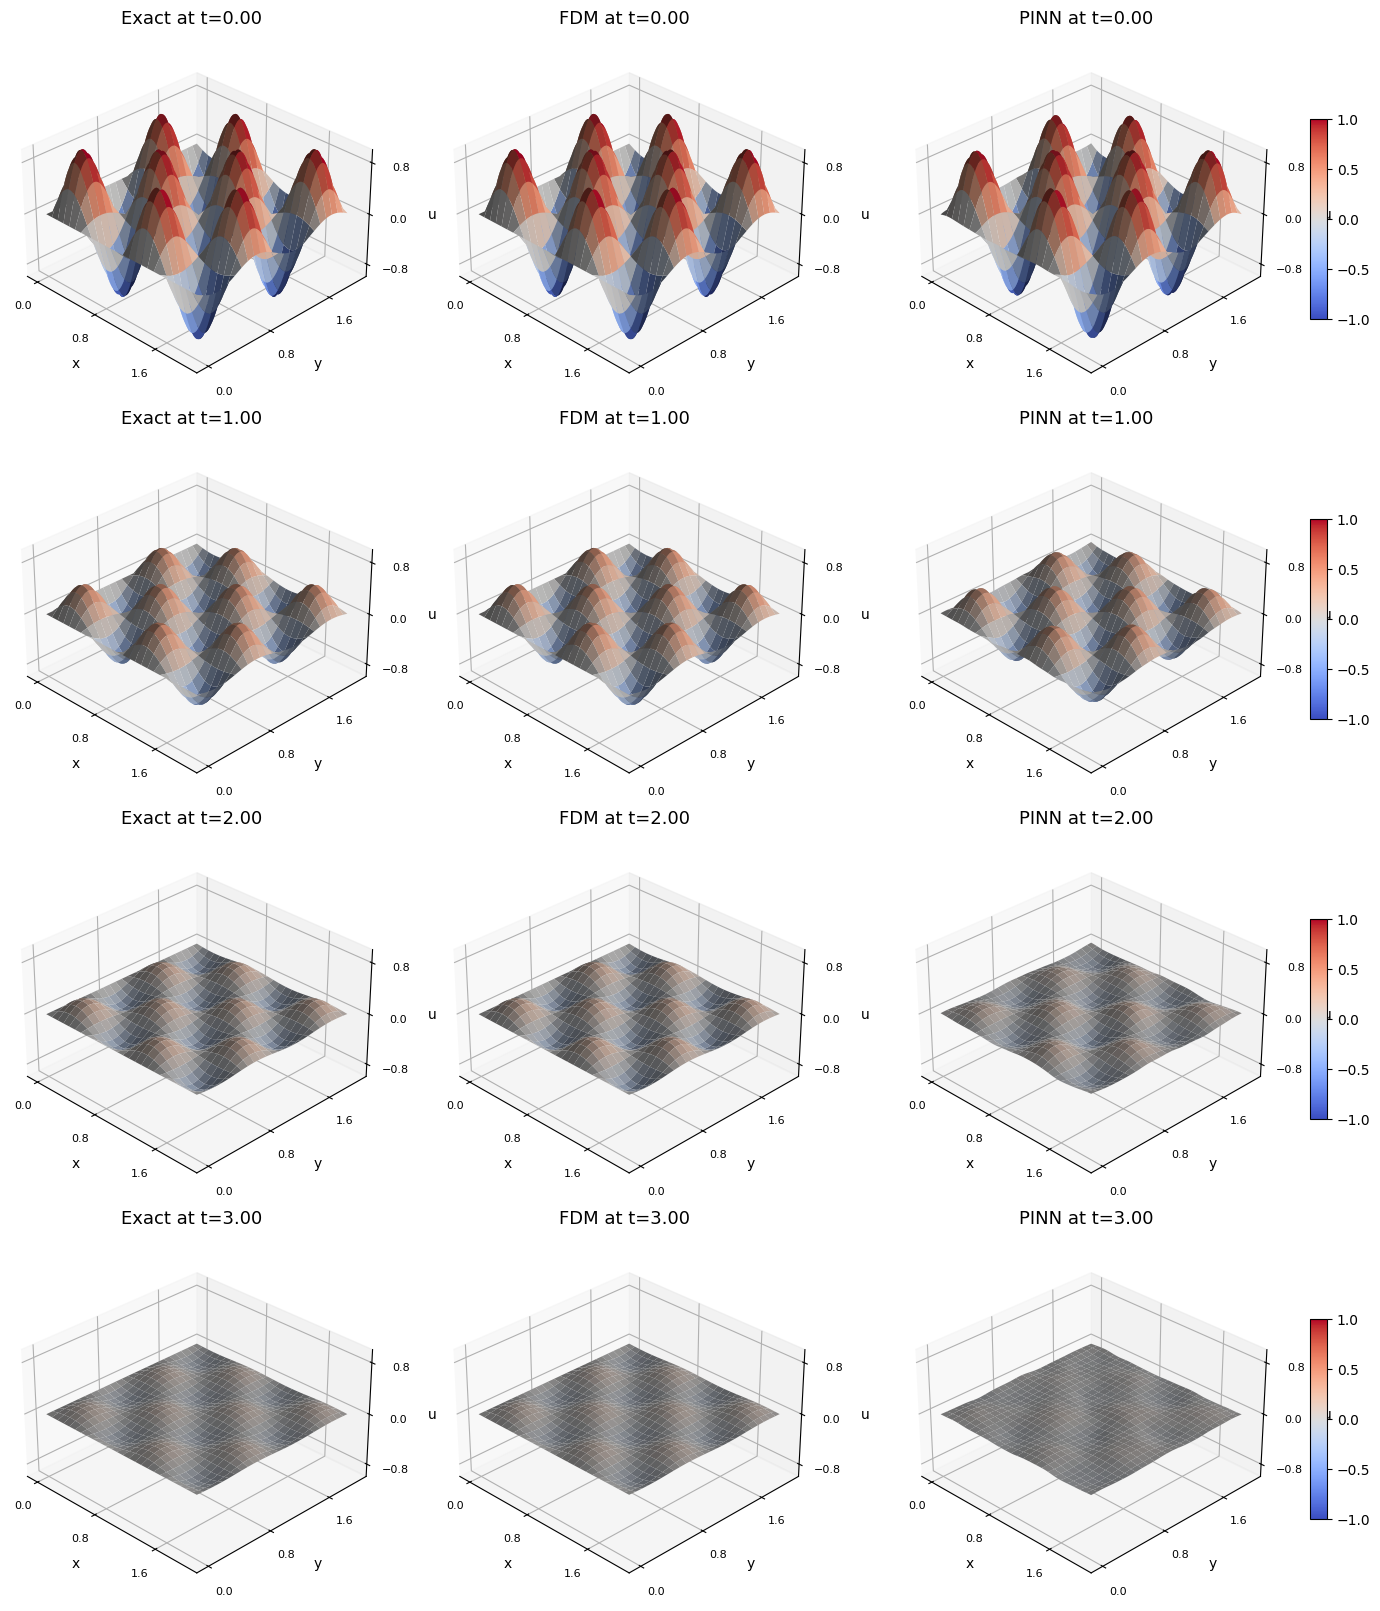

In [6]:
"""
2D Heat Equation Comparison: PINN vs FDM vs Exact (3D surfaces with colormap)
==============================================================================
This script solves u_t = alpha*(u_xx + u_yy) on a periodic square [0,L]^2,
with initial condition u(x,y,0) = sin(2*pi*k*x/L)*sin(2*pi*k*y/L).

It computes:
  1) Exact solution,
  2) Finite‐difference (FDM) solution,
  3) PINN solution with Fourier features,

and then shows 3D surface plots (Exact | FDM | PINN) at t = [0, 3.33, 6.67, 10.0]
using a coolwarm colormap centered at zero for clear temperature contrast.
"""

import numpy as np
import math
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colors
from torch.autograd import grad

# Device (assume MPS on Mac)
device = torch.device('mps')
print(f"Using device: {device}")

# Parameters
alpha = 0.01     # diffusion coefficient
L     = 2.0      # domain size
k     = 2        # frequency
times = [0, 1, 2, 3]
Nx = Ny = 100    # spatial grid resolution
dt = 1e-4        # FDM time step

# -----------------------------------------------------------------------------
# 1) Exact 2D solution
# -----------------------------------------------------------------------------
def exact_solution(x, y, t, alpha=alpha, k=k, L=L):
    decay = math.exp(-alpha * (2*math.pi*k/L)**2 * 2 * t)
    return decay * np.sin(2*math.pi*k * x / L) * np.sin(2*math.pi*k * y / L)

# -----------------------------------------------------------------------------
# 2) Explicit 2D Finite Difference Solver
# -----------------------------------------------------------------------------
class HeatFDM2D:
    def __init__(self, alpha, L, Nx, Ny, dt, t_max):
        self.alpha = alpha; self.L = L
        self.Nx = Nx; self.Ny = Ny
        self.dt = dt; self.t_max = t_max
        self.dx = L/Nx; self.dy = L/Ny

        # periodic grid
        self.x = np.linspace(0, L, Nx, endpoint=False)
        self.y = np.linspace(0, L, Ny, endpoint=False)
        X, Y = np.meshgrid(self.x, self.y, indexing='ij')
        self.u = np.sin(2*np.pi*k*X/L) * np.sin(2*np.pi*k*Y/L)
        self.history = {}

    def step(self):
        u = self.u
        u_xp = np.roll(u, -1, axis=0)
        u_xm = np.roll(u, +1, axis=0)
        u_yp = np.roll(u, -1, axis=1)
        u_ym = np.roll(u, +1, axis=1)
        lap = (u_xp - 2*u + u_xm)/(self.dx**2) + (u_yp - 2*u + u_ym)/(self.dy**2)
        self.u = u + self.alpha * self.dt * lap

    def solve(self, times):
        # reset
        X, Y = np.meshgrid(self.x, self.y, indexing='ij')
        self.u = np.sin(2*np.pi*k*X/L) * np.sin(2*np.pi*k*Y/L)
        self.history = {t: None for t in times}
        t = 0.0
        times_sorted = sorted(times)
        next_t = times_sorted.pop(0)

        while t < self.t_max + self.dt:
            if t >= next_t - 1e-8:
                self.history[next_t] = self.u.copy()
                if times_sorted:
                    next_t = times_sorted.pop(0)
                else:
                    break
            self.step()
            t += self.dt

        return self.x, self.y, self.history

# -----------------------------------------------------------------------------
# 3) PINN: Fourier Feature + MLP
# -----------------------------------------------------------------------------
class FourierFeatures(nn.Module):
    def __init__(self, in_dim, m=100, scale=1.0):
        super().__init__()
        B = torch.randn(in_dim, m) * scale
        self.register_buffer('B', B)

    def forward(self, x):
        # x: [N, in_dim]
        xp = 2*math.pi * x @ self.B
        return torch.cat([torch.sin(xp), torch.cos(xp)], dim=-1)

class PINN2D(nn.Module):
    def __init__(self, alpha, L, hidden=[128,128], m=100):
        super().__init__()
        self.alpha = alpha; self.L = L
        self.ff = FourierFeatures(3, m)
        layers = []
        in_dim = 2*m
        for h in hidden:
            layers += [nn.Linear(in_dim, h), nn.Tanh()]
            in_dim = h
        layers += [nn.Linear(in_dim, 1)]
        self.net = nn.Sequential(*layers)

    def forward(self, x, y, t):
        inp = torch.cat([x, y, t], dim=-1)
        phi = self.ff(inp)
        return self.net(phi)

    def loss_pde(self, x, y, t):
        x.requires_grad_(True); y.requires_grad_(True); t.requires_grad_(True)
        u = self.forward(x, y, t)
        u_t  = grad(u, t, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_x  = grad(u, x, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_xx = grad(u_x, x, grad_outputs=torch.ones_like(u_x), create_graph=True)[0]
        u_y  = grad(u, y, grad_outputs=torch.ones_like(u), create_graph=True)[0]
        u_yy = grad(u_y, y, grad_outputs=torch.ones_like(u_y), create_graph=True)[0]
        return torch.mean((u_t - self.alpha*(u_xx + u_yy))**2)

    def loss_ic(self, x0, y0):
        u0_true = torch.sin(2*math.pi*k*x0/self.L) * torch.sin(2*math.pi*k*y0/self.L)
        u0_pred = self.forward(x0, y0, torch.zeros_like(x0))
        return torch.mean((u0_pred - u0_true)**2)

    def loss_bc(self, xb, yb, tb):
        # periodic in x & y: match values and first derivatives
        xb0 = torch.zeros_like(yb, requires_grad=True)
        xbL = torch.ones_like(yb, requires_grad=True) * self.L
        yb0 = torch.zeros_like(xb, requires_grad=True)
        ybL = torch.ones_like(xb, requires_grad=True) * self.L

        u_x0 = self.forward(xb0, yb, tb)
        u_xL = self.forward(xbL, yb, tb)
        u_y0 = self.forward(xb, yb0, tb)
        u_yL = self.forward(xb, ybL, tb)

        u_x0_x = grad(u_x0, xb0, grad_outputs=torch.ones_like(u_x0), create_graph=True)[0]
        u_xL_x = grad(u_xL, xbL, grad_outputs=torch.ones_like(u_xL), create_graph=True)[0]
        u_y0_y = grad(u_y0, yb0, grad_outputs=torch.ones_like(u_y0), create_graph=True)[0]
        u_yL_y = grad(u_yL, ybL, grad_outputs=torch.ones_like(u_yL), create_graph=True)[0]

        return (
            torch.mean((u_x0 - u_xL)**2) +
            torch.mean((u_x0_x - u_xL_x)**2) +
            torch.mean((u_y0 - u_yL)**2) +
            torch.mean((u_y0_y - u_yL_y)**2)
        )

def train_pinn2d(model, epochs=5000, lr=1e-3,
                 N_pde=5000, N_ic=500, N_bc=500):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    for ep in range(1, epochs+1):
        x_pde = torch.rand(N_pde,1,device=device)*L
        y_pde = torch.rand(N_pde,1,device=device)*L
        t_pde = torch.rand(N_pde,1,device=device)*10.0
        x_ic  = torch.rand(N_ic,1, device=device)*L
        y_ic  = torch.rand(N_ic,1, device=device)*L
        x_bc  = torch.rand(N_bc,1, device=device)*L
        y_bc  = torch.rand(N_bc,1, device=device)*L
        t_bc  = torch.rand(N_bc,1, device=device)*10.0

        lpde = model.loss_pde(x_pde, y_pde, t_pde)
        lic  = model.loss_ic(x_ic, y_ic)
        lbc  = model.loss_bc(x_bc, y_bc, t_bc)

        loss = lpde + lic + lbc
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if ep % 500 == 0:
            print(f"Epoch {ep}/{epochs}  Loss: {loss.item():.3e}, "
                  f"PDE {lpde.item():.3e}, IC {lic.item():.3e}, BC {lbc.item():.3e}")
    return model

# -----------------------------------------------------------------------------
# Main: solve FDM, train PINN, then 3D‐plot comparisons
# -----------------------------------------------------------------------------
if __name__ == '__main__':
    # FDM
    fdm2d = HeatFDM2D(alpha, L, Nx, Ny, dt, max(times))
    x_fd, y_fd, fd_hist = fdm2d.solve(times)

    # PINN
    pinn2d = PINN2D(alpha, L).to(device)
    pinn2d = train_pinn2d(pinn2d)

    # Prepare mesh for plotting
    Xg, Yg = np.meshgrid(x_fd, y_fd, indexing='ij')

    
    A = 1.0
    norm = colors.Normalize(vmin=-A, vmax=A)

    fig, axes = plt.subplots(
        nrows=len(times),
        ncols=3,
        figsize=(14, 4 * len(times)),
        subplot_kw=dict(projection="3d", box_aspect=(1, 1, 0.6)),
        constrained_layout=True,
    )

    # consistent camera
    elev, azim = 30, -45   # adjust if you prefer a different view

    for i, t in enumerate(times):
        # --- data --------------------------------------------------------
        u_ex = exact_solution(Xg, Yg, t)
        u_fd = fd_hist[t]
        xg   = torch.tensor(Xg.ravel()[:, None], dtype=torch.float32, device=device)
        yg   = torch.tensor(Yg.ravel()[:, None], dtype=torch.float32, device=device)
        tg   = torch.full_like(xg, t)
        with torch.no_grad():
            u_p = pinn2d(xg, yg, tg).cpu().numpy().reshape(Xg.shape)

        for j, (data, title) in enumerate([(u_ex, "Exact"),
                                        (u_fd,  "FDM"),
                                        (u_p,   "PINN")]):

            ax = axes[i, j]
            surf = ax.plot_surface(
                Xg, Yg, data,
                facecolors=cm.coolwarm(norm(data)),
                rstride=4, cstride=4,
                linewidth=0, antialiased=True,
            )

            # axis ranges / ticks
            ax.set_zlim(-A, A)
            for axis in (ax.xaxis, ax.yaxis, ax.zaxis):
                axis.set_major_locator(MaxNLocator(3))        # ⇐ ≤ 3 numbers
            ax.tick_params(labelsize=8)

            # labels
            ax.set_xlabel("x")
            ax.set_ylabel("y")
            ax.set_zlabel("u")

            # title
            ax.set_title(f"{title} at t={t:.2f}",
                        fontsize=13, pad=10)

            # camera
            ax.view_init(elev=elev, azim=azim)

            # colour-bar only once per row (right-most panel)
            if j == 2:
                m = cm.ScalarMappable(norm=norm, cmap="coolwarm")
                m.set_array([])
                fig.colorbar(m, ax=ax, shrink=0.55, aspect=12, pad=0.10)

    # minimal outer margins
    fig.subplots_adjust(top=0.95, bottom=0.03, wspace=0.05, hspace=0.15)
    plt.show()

# Epoch 5000/5000  Loss: 3.750e-03, PDE 1.609e-03, IC 1.239e-04, BC 2.017e-03 - 2.5 minutes of runtime